In [ ]:
!pip install rdkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
CUDA_LAUNCH_BLOCKING = "1"

from sklearn.metrics import log_loss, mean_absolute_error, mean_squared_error
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from google.colab import drive
import math
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
import os
import seaborn as sb
from collections import Counter
from dataframe_pipeline_script import Dataset
#drive.mount('/content/drive')


In [6]:
#path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
path = "DATA/fingerprint_df.csv"
df = pd.read_csv(path)
df.head()

,index,Unnamed: 0.1,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,...,fp122,fp123,fp124,fp125,fp126,fp127,fp128,binary_rat_ld50,LD50_level,LD50_rat_level
0,0,0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734.0,As,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
1,1,1,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338.0,C2H3Cl,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,2,2,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241.0,C6H6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
3,3,3,5,8,T3D0007,Cadmium,Cadmium (group IIB of the periodic table of el...,7440-43-9,31193.0,Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,4,5,9,13,T3D0012,Clofenotane,Insecticide. Clofenotane is a major component ...,50-29-3,3036.0,C14H9Cl5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [183]:
B = 8 #Reduce this if your GPU runs out of memory
valset = Dataset(data=df, label="LD50_rat_level", purpose="val", shuffle=True, qed=False, max_len=225)
valloader = torch.utils.data.DataLoader(dataset=valset,batch_size=B,shuffle=False,drop_last=True)

trainset = Dataset(data=df, label="LD50_rat_level", purpose="train", shuffle=True, qed=False, max_len=225)
trainloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=B,shuffle=False,drop_last=True)



Val
Length of longest string: 225
Largest embedding value: 124.0
Number of unique embedding values: 49
x shape: torch.Size([170, 226])
t shape: torch.Size([170, 3])

Train
Length of longest string: 225
Largest embedding value: 124.0
Number of unique embedding values: 45
x shape: torch.Size([394, 226])
t shape: torch.Size([394, 3])


In [184]:
# you can access initialised variables from the Dataset class by calling the variables as arguments of the instance:
print(trainset.n_map)
print(trainset.max_map)
print(valset.max_len)

45
124.0
225


In [185]:
### GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 22 21:41:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:10:00.0  On |                  N/A |
|  0%   58C    P8    32W / 350W |   3674MiB / 24576MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [261]:
class Head(torch.nn.Module):
    def __init__(self,head_size, n_embd):
        super().__init__()
        self.key = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.query = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.value = torch.nn.Linear(int(n_embd), int(head_size), bias=False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = torch.nn.functional.softmax(wei,dim=-1) #softmax needs to be performed along the sequence axis (_,seq,_) 
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    
class MultiHeadAttention(torch.nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = torch.nn.ModuleList([Head(int(head_size), int(n_embd)) for _ in range(num_heads)])
        self.proj = torch.nn.Linear(int(n_embd), int(n_embd))
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) #
        out = self.dropout(self.proj(out))
        return out        

class FeedForward(torch.nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(int(n_embd), 4 * int(n_embd)),
            torch.nn.ReLU(), #investigate GeLU instead of ReLU
            torch.nn.Linear(4 * int(n_embd), int(n_embd)),
            torch.nn.Dropout(dropout), #dropout helps with overfitting
        )

    def forward(self, x):
        return self.net(x)
    
class Encoder(torch.nn.Module): # encoder needed for when  have the full data (maybe)
    """Decoder block: communication followed by computation """

    def __init__(self, n_embd, n_head, head_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = MultiHeadAttention(n_head, head_size, n_embd)
        self.ffwd = FeedForward(int(n_embd))
        self.ln1 = torch.nn.LayerNorm(int(n_embd))
        self.ln2 = torch.nn.LayerNorm(int(n_embd)) #layernorm is not switched off at eval. so it is not buffered 

        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) #in residual connection, addition distributes gradients equally to all of its branches.    
        #consider switching the Layernorm to after the computation
        x = x + self.ffwd(self.ln2(x)) #LayerNorm before the transformation instead of after avoids the instability of the training due to large output gradients 
        return x

class PositionalEncoding(torch.nn.Module):
    def __init__(self, n_embd, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, n_embd)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2).float() * (-math.log(10000.0) / n_embd))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1),:] #consider removing dropout and plotting the layer
        return x#self.dropout(x)

In [262]:
class ClassificationTransformer(torch.nn.Module):

    def __init__(self,n_embd,n_head,n_layers,n_class):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        head_size = int(n_embd) // n_head
        self.token_embedder = torch.nn.Embedding(int(trainset.max_map+1), n_embd)
        self.position_embedder = PositionalEncoding(n_embd)
        self.EncoderBlock = torch.nn.Sequential(*[Encoder(n_embd=n_embd, n_head=n_head, head_size=head_size) for _ in range(n_layers)])
        
        self.out_map = torch.nn.Linear(int(trainset[0][0].shape[0])*n_embd,n_class)
        
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedder(x.long())
        x = self.position_embedder(token_emb) # (B,T,C)

        x = self.EncoderBlock(x) # (B,T,C)
        
        x = torch.flatten(x,start_dim=-2, end_dim=-1)
        y = self.out_map(x)
        y = self.softmax(y)
        return y

In [263]:
dropout = 0.8
n_embd = 512
n_head = 1
n_layers = 1
transformer = ClassificationTransformer(n_embd=n_embd,n_head=n_head,n_layers=n_layers,n_class=int(max(df.LD50_rat_level)))
total_params = sum(param.numel() for param in transformer.parameters())

print(f"Total model parameters: {total_params}")

Total model parameters: 3561987


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.390708599771772
Epoch 1; train loss: 0.96661	 val loss: 1.39071


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.3907040698187692
Epoch 2; train loss: 0.96469	 val loss: 1.39070


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.3906900542122977
Epoch 3; train loss: 0.96469	 val loss: 1.39069


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.3906272422699701
Epoch 4; train loss: 0.96467	 val loss: 1.39063


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1919873385202318
Epoch 5; train loss: 0.95119	 val loss: 1.19199


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1243942096119834
Epoch 6; train loss: 0.81041	 val loss: 1.12439


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1230542659759521
Epoch 7; train loss: 0.78111	 val loss: 1.12305


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1112631190390814
Epoch 8; train loss: 0.76616	 val loss: 1.11126


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1088092525800068
Epoch 9; train loss: 0.75894	 val loss: 1.10881


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1052803198496501
Epoch 10; train loss: 0.75592	 val loss: 1.10528


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.104364466099512
Epoch 11; train loss: 0.75536	 val loss: 1.10436


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.103371228490557
Epoch 12; train loss: 0.75389	 val loss: 1.10337


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1063280077207656
Epoch 13; train loss: 0.74701	 val loss: 1.10633


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1047600763184684
Epoch 14; train loss: 0.74716	 val loss: 1.10476


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.111843222663516
Epoch 15; train loss: 0.74408	 val loss: 1.11184


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1099904151189894
Epoch 16; train loss: 0.73886	 val loss: 1.10999


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1123862805820646
Epoch 17; train loss: 0.73944	 val loss: 1.11239


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1089088405881609
Epoch 18; train loss: 0.73784	 val loss: 1.10891


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1097091010638647
Epoch 19; train loss: 0.73650	 val loss: 1.10971


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1092272656304496
Epoch 20; train loss: 0.73597	 val loss: 1.10923


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1075792851902189
Epoch 21; train loss: 0.73595	 val loss: 1.10758


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.104016125202179
Epoch 22; train loss: 0.73647	 val loss: 1.10402


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1085411537261236
Epoch 23; train loss: 0.73660	 val loss: 1.10854


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1078623817080544
Epoch 24; train loss: 0.73531	 val loss: 1.10786


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1048794644219535
Epoch 25; train loss: 0.73557	 val loss: 1.10488


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1085563188507443
Epoch 26; train loss: 0.73487	 val loss: 1.10856


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1010621928033375
Epoch 27; train loss: 0.73524	 val loss: 1.10106


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1032788441294716
Epoch 28; train loss: 0.73518	 val loss: 1.10328


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1124022063754855
Epoch 29; train loss: 0.73613	 val loss: 1.11240


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1032342598551796
Epoch 30; train loss: 0.73429	 val loss: 1.10323


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.105812396321978
Epoch 31; train loss: 0.73543	 val loss: 1.10581


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.102109928925832
Epoch 32; train loss: 0.73482	 val loss: 1.10211


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1068041494914465
Epoch 33; train loss: 0.73382	 val loss: 1.10680


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1042951969873338
Epoch 34; train loss: 0.73279	 val loss: 1.10430


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1004716612043834
Epoch 35; train loss: 0.73274	 val loss: 1.10047


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1407923272677831
Epoch 36; train loss: 0.73269	 val loss: 1.14079


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1001824566296168
Epoch 37; train loss: 0.73489	 val loss: 1.10018


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1028098265329997
Epoch 38; train loss: 0.73338	 val loss: 1.10281


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.102541915008
Epoch 39; train loss: 0.73063	 val loss: 1.10254


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1240971570923215
Epoch 40; train loss: 0.73181	 val loss: 1.12410


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1037733157475789
Epoch 41; train loss: 0.72962	 val loss: 1.10377


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0985738918894814
Epoch 42; train loss: 0.72869	 val loss: 1.09857


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.0997029684838795
Epoch 43; train loss: 0.73049	 val loss: 1.09970


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1014254291852315
Epoch 44; train loss: 0.72723	 val loss: 1.10143


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1006925985926674
Epoch 45; train loss: 0.73289	 val loss: 1.10069


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1044358355658395
Epoch 46; train loss: 0.72605	 val loss: 1.10444


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1006198355129786
Epoch 47; train loss: 0.72994	 val loss: 1.10062


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1023491621017456
Epoch 48; train loss: 0.72533	 val loss: 1.10235


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1013588053839547
Epoch 49; train loss: 0.73233	 val loss: 1.10136


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1.1048192239943004
Epoch 50; train loss: 0.72859	 val loss: 1.10482


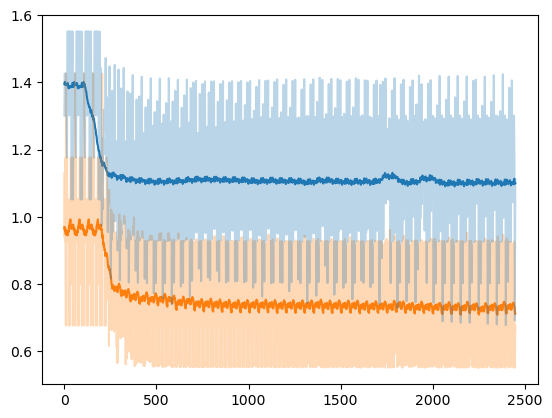

In [264]:
device = torch.device("cuda")
optimizer = torch.optim.AdamW(params=transformer.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()

transformer = transformer.to(device)
train_plot = []
val_plot = []
best = 10
train_loader = trainloader
val_loader = valloader
train_set = trainset
val_set = valset
for epoch in tqdm(range(50)):
    train_loss = val_loss = 0
    transformer.train()
    for x,t in tqdm(train_loader):
        
        
        x = x.float()
        t = t.float()
        optimizer.zero_grad()
        data = transformer(x.to(device)).float()
        J = loss(data, t.to(device))
        train_plot.append(J.item())
        train_loss += J.item()
        J.backward()
        optimizer.step()
        
    transformer.eval()
    for x,t in tqdm(val_loader):
        with torch.no_grad():
            
            x = x.float()
            t = t.float()
            data = transformer(x.to(device)).float()
            J = loss(data, t.to(device))
            val_loss += J.item()
            val_plot.append(J.item())
    print(val_loss/len(val_loader))
    if (val_loss/len(val_loader)) < best:
        best = (val_loss/len(val_loader))
        try:
            torch.save(transformer.state_dict(), f"/content/drive/My Drive/Toxicity Project/Saved_models/toxformer_categorical_encoderonly_params.pth") ### saving the model with best validation loss is a bias!!!
        except RuntimeError:
            torch.save(transformer.state_dict(), f"Saved_models/toxformer_categorical_encoderonly_params.pth")
    print(f"\rEpoch {epoch+1}; train loss: {train_loss/len(train_loader):1.5f}\t val loss: {val_loss/len(val_loader):1.5f}")
##### print the loss calcualted by hand (custom function) more reliable
R=B*5
ma_train = np.convolve(train_plot, np.ones(R)/R, mode="valid")
ma_val = np.convolve(val_plot, np.ones(R)/R, mode="valid")
plt.plot(np.linspace(0,len(train_plot)-1,len(ma_train)),ma_train,c="tab:orange")
plt.plot(np.linspace(0,len(train_plot)-1,len(ma_val)),ma_val, c="tab:blue")
plt.plot(train_plot,c="tab:orange",alpha=0.3)
plt.plot(np.linspace(0,len(train_plot)-1,len(val_plot)),val_plot,c="tab:blue",alpha=0.3)


In [265]:
def probability(arr):
    n = len(arr)
    count = Counter(arr)
    result = []
    for i in range(0, max(arr) + 1):
        result.append(count[i] / n)
    return result

In [266]:
t = torch.argmax(valset.make()[1],dim=-1).numpy()
pmean = probability(t)
cce = log_loss(t,np.full((len(t),len(pmean)),pmean))
print("CCE of the mean:")
print(cce)

CCE of the mean:
1.0182818144702934


In [267]:
transformer.load_state_dict(torch.load("Saved_models/toxformer_categorical_encoderonly_params.pth"))

<All keys matched successfully>

In [268]:
def confusion_matrix(y_true, y_pred, n_cls=3):
    """
    Calculate the confusion matrix for a multi-class classification task with 3 classes.
    
    Parameters:
    y_true: 1D array of integers representing the true labels
    y_pred: 1D array of integers representing the predicted labels
    
    Returns:
    Confusion matrix (2D array of integers)
    """
    # initialize the confusion matrix
    cm = np.zeros((n_cls, n_cls))
    
    # populate the confusion matrix
    for true_label, pred_label in zip(y_true, y_pred):
        cm[pred_label,true_label] += 1

    cm_norm = cm.copy()
    print(cm_norm)
    for i in range(len(cm_norm)):
        cm_norm[:,i] = cm_norm[:,i]/sum(cm_norm[:,i])
    print(cm_norm)
    plt.figure()
    plt.imshow(cm_norm)
    # add the numbers to the plot squares
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i, j]:0.3f}", ha='center', va='center')
    plt.locator_params(nbins=4)
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    plt.show()

    plt.figure()
    plt.imshow(cm)
    # add the numbers to the plot squares
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.locator_params(nbins=4)
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    plt.show()

    return cm, cm_norm

In [269]:
device = torch.device("cuda")
val_loss=0
targets = np.array([])
predictions = np.array([])
probabilities = []
for x,t in tqdm(val_loader):
    transformer.eval()
    with torch.no_grad():
        x = x.float()
        t = t.float()
        data = transformer(x.to(device)).float()
        y = torch.nn.functional.softmax(data,dim=-1)
        
        preds = torch.argmax(y,dim=-1)
        targs = torch.argmax(t,dim=-1)
        preds = preds.cpu().detach().numpy().astype(int)
        targs = targs.cpu().detach().numpy().astype(int)
        probabilities.append(y.cpu().detach().numpy())
        predictions = np.append(predictions,preds).astype(int)
        targets = np.append(targets, targs).astype(int)
        f = torch.nn.functional.cross_entropy(data, t.to(device))
        val_loss += f.item()
print(f"CCE: {val_loss/len(val_loader)}")
probabilities = np.stack(probabilities)
probabilities = np.reshape(probabilities,(probabilities.shape[0]*probabilities.shape[1],probabilities.shape[-1]))
MAE = mean_absolute_error(targets, predictions)
MAE_mean = mean_absolute_error(targets, np.full(len(targets),np.mean(targets)))
MAE_median = mean_absolute_error(targets, np.full(len(targets),np.median(targets)))

print(f"MAE of model: {MAE}")
print(f"MAE of mean (benchmark): {MAE_mean}")
print(f"MAE of median (benchmark): {MAE_median}")

  0%|          | 0/21 [00:00<?, ?it/s]

CCE: 1.0985738918894814
MAE of model: 0.9285714285714286
MAE of mean (benchmark): 0.8455215419501133
MAE of median (benchmark): 0.8392857142857143


In [270]:
(mean_absolute_error(targets, predictions))

0.9285714285714286

[[76. 27. 64.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
[[1.         1.         0.98461538]
 [0.         0.         0.01538462]
 [0.         0.         0.        ]]


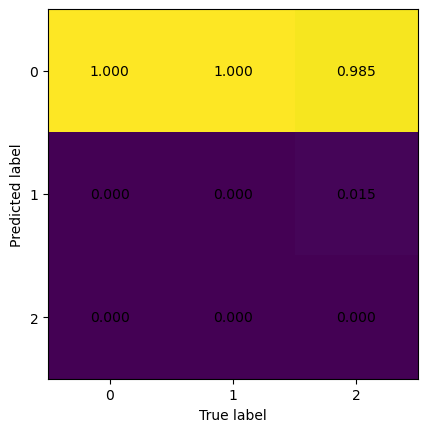

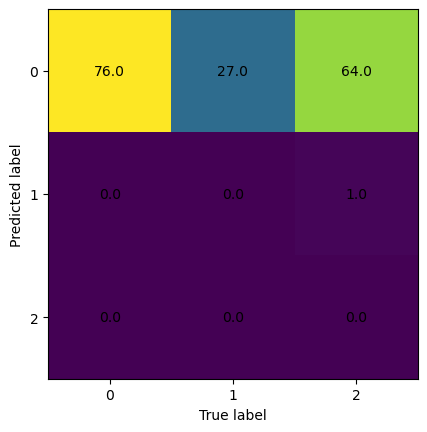

In [272]:
cm, cm_norm = confusion_matrix(targets,predictions)